In [85]:
import os
import json
import re
import pandas as pd

def extract_final_answer(text):
    match = re.search(r'final answer:\s*\(([A-Za-z])\)', text, re.IGNORECASE)
    if match:
        return match.group(1)
    pattern = re.compile(r'answer:\s*([A-Za-z])', re.IGNORECASE)
    match = pattern.search(text)
    if match:
        return match.group(1)
    pattern = re.compile(r'answer:\s*\*\*([A-Za-z])\*\*\.?', re.IGNORECASE)
    match = pattern.search(text)
    if match:
        return match.group(1)
    pattern = re.compile(r'answer:\s*\(([A-Za-z])\)', re.IGNORECASE)
    match = pattern.search(text)
    if match:
        return match.group(1)
    return None

def original_extract_answer(response):
    response = response.replace('*', '')
    match = re.search(r'The correct answer is \(([A-D])\)', response)
    if match:
        return match.group(1)
    else:
        match = re.search(r'The correct answer is ([A-D])', response)
        if match:
            return match.group(1)
        else:
            return None

def last_boxed_only_string(string: str):
    idx = string.rfind("boxed")
    if idx == -1:
        idx = string.rfind("\\fbox")
    if idx == -1:
        return None
    i = idx
    num_left_braces_open = 0
    right_brace_idx = None
    while i < len(string):
        if string[i] == "{":
            num_left_braces_open += 1
        elif string[i] == "}":
            num_left_braces_open -= 1
            if num_left_braces_open == 0:
                right_brace_idx = i
                break
        i += 1
    if right_brace_idx is None:
        return None
    return string[idx:right_brace_idx + 1]

def remove_boxed(boxed_str):
    if boxed_str.startswith('boxed{') and boxed_str.endswith('}'):
        return boxed_str[len('boxed{'):-1].strip()
    if boxed_str.startswith('\\fbox{') and boxed_str.endswith('}'):
        return boxed_str[len('\\fbox{'):-1].strip()
    return boxed_str.strip()

def extract_boxed_answer(text):
    boxed_content = last_boxed_only_string(text)
    if boxed_content:
        inner_text = remove_boxed(boxed_content)
        match = re.search(r"\((\w)\)", inner_text)
        if match:
            return match.group(1).upper()
    return None

def evaluate(file_path, mode='standard'):
    files = [file_path]
    columns = ['Model', 'Overall', 'Easy', 'Hard', 'Short', 'Medium', 'Long',
               'Long In-context Learning', 'Long Structured Data Understanding', 'Code Repository Understanding',
               'Single-Document QA', 'Long-dialogue History Understanding', 'Multi-Document QA']
    results_df = pd.DataFrame(columns=columns)

    all_domains = set()
    for file in files:
        pred_data = [json.loads(line) for line in open(os.path.join('results', file), encoding='utf-8')]
        for pred in pred_data:
            all_domains.add(pred['domain'])

    for file in files:
        pred_data = [json.loads(line) for line in open(os.path.join('results', file), encoding='utf-8')]

        metrics = {'easy': [0, 0], 'hard': [0, 0], 'short': [0, 0], 'medium': [0, 0], 'long': [0, 0]}
        domain_dict = {domain: [0, 0] for domain in all_domains}

        for pred in pred_data:
            pred_option = None
            if mode == 'boxed':
                pred_option = extract_boxed_answer(pred.get("response_cot", ""))
            elif mode == 'standard':
                if pred["pred"] is None and "response_cot" in pred:
                    pred_option = extract_final_answer(pred["response_cot"])
                else:
                    pred_option = pred['pred']
            elif mode == 'mix':
                pred_option = extract_boxed_answer(pred.get("response_cot", ""))
                if not pred_option:
                    if pred["pred"] is None:
                        pred_option = extract_final_answer(pred["response_cot"])
                    else:
                        pred_option = pred['pred']
            elif mode == 'original':
                pred_option = original_extract_answer(pred.get("response", ""))
                # if not pred_option:
                    
                #     pred_option = original_extract_answer(pred.get('response_cot', ""))
            else:
                raise ValueError(f"Unknown mode: {mode}")

            pred['judge'] = pred_option == pred['answer']

            difficulty, length, domain = pred["difficulty"], pred["length"], pred["domain"]
            metrics[difficulty][0] += pred['judge']
            metrics[difficulty][1] += 1
            metrics[length][0] += pred['judge']
            metrics[length][1] += 1

            domain_dict[domain][0] += pred['judge']
            domain_dict[domain][1] += 1

        total_acc = sum([v[0] for v in metrics.values()])
        total_qs = sum([v[1] for v in metrics.values()])
        model_results = {
            'Model': '.'.join(file.split('.')[:-1]),
            'Overall': round(100 * total_acc / total_qs, 1) if total_qs else 0,
            'Easy': round(100 * metrics['easy'][0] / metrics['easy'][1], 1) if metrics['easy'][1] else 0,
            'Hard': round(100 * metrics['hard'][0] / metrics['hard'][1], 1) if metrics['hard'][1] else 0,
            'Short': round(100 * metrics['short'][0] / metrics['short'][1], 1) if metrics['short'][1] else 0,
            'Medium': round(100 * metrics['medium'][0] / metrics['medium'][1], 1) if metrics['medium'][1] else 0,
            'Long': round(100 * metrics['long'][0] / metrics['long'][1], 1) if metrics['long'][1] else 0,
        }
        print(model_results)
        for domain in all_domains:
            domain_accuracy = round(100 * domain_dict[domain][0] / domain_dict[domain][1], 1) if domain_dict[domain][1] else 0.0
            model_results[domain] = domain_accuracy

        results_df = pd.concat([results_df, pd.DataFrame([model_results])], ignore_index=True)

    filename = f'result_{mode}.csv'
    # results_df.to_csv(filename, index=False, encoding='utf-8')
    return pred_data

In [104]:
pred = evaluate("/home/aiscuser/LongBench-v2/results/Qwen2.5-7B-Instruct-YaRN_temp0.0_cot.jsonl", mode='original')
# pred = evaluate("/home/aiscuser/LongBench-v2/results/Qwen2.5-14B-Instruct-Yarn_temp0.1_cot-20250811_152621.jsonl", mode='original')

{'Model': '/home/aiscuser/LongBench-v2/results/Qwen2.5-7B-Instruct-YaRN_temp0.0_cot', 'Overall': 31.2, 'Easy': 32.3, 'Hard': 30.5, 'Short': 42.8, 'Medium': 24.7, 'Long': 25.0}


/tmp/ipykernel_1546093/3963795321.py:144: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([model_results])], ignore_index=True)


In [106]:
from datasets import load_dataset
lb2 = load_dataset("zai-org/LongBench-v2", split="train")
lb2_dict = {}
for item in lb2:
    lb2_dict[item['_id']] = item
lb2_len_dict={}

In [ ]:
from concurrent.futures import ThreadPoolExecutor
from transformers import AutoTokenizer
from tqdm import tqdm

# ---- config ----
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"
NUM_WORKERS = 64  # 根据CPU核心数调整
K = 1024

tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

# 区间（单位=1024 tokens）
bins = [(0, 16*K), (16*K, 32*K), (32*K, 64*K), (64*K, float("inf"))]
bin_labels = ["0-16k", "16k-32k", "32k-64k", ">64k"]

def which_bin(length: int) -> str:
    for (low, high), label in zip(bins, bin_labels):
        if low <= length < high:
            return label
    return ">64k"  

# lb2_len_dict={}

def compute_len_and_judge(item):
    # 返回 (length, judge)
    if item['_id'] in lb2_len_dict:
        return lb2_len_dict[item['_id']], item['judge']
    ctx = lb2_dict[item["_id"]]["context"]
    # 若你不想算上特殊token，可设置 add_special_tokens=False
    length = len(tok.encode(ctx))
    judge = bool(item["judge"])
    lb2_len_dict[item['_id']] = length
    return length, judge

# 1) 并行计算所有 (length, judge)
results = []
with ThreadPoolExecutor(max_workers=NUM_WORKERS) as ex:
    for length, judge in tqdm(ex.map(compute_len_and_judge, pred), total=len(pred), desc="Tokenizing"):
        results.append((length, judge))

# 2) 统计
stats = {label: {"total": 0, "correct": 0} for label in bin_labels}
for length, judge in results:
    label = which_bin(length)
    stats[label]["total"] += 1
    if judge:
        stats[label]["correct"] += 1

# 3) 打印结果
for label in bin_labels:
    total = stats[label]["total"]
    correct = stats[label]["correct"]
    acc = correct / total if total > 0 else 0.0
    print(f"{label}: total={total}, correct={correct}, accuracy={acc:.2%}")

Token indices sequence length is longer than the specified maximum sequence length for this model (149466 > 131072). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (181523 > 131072). Running this sequence through the model will result in indexing errors
Tokenizing:   1%|          | 3/503 [00:05<13:54,  1.67s/it]

       bin  total  correct  accuracy
0    0-16k     29       14  0.482759
1  16k-32k     87       37  0.425287
2  32k-64k     68       35  0.514706
3     >64k    319      111  0.347962


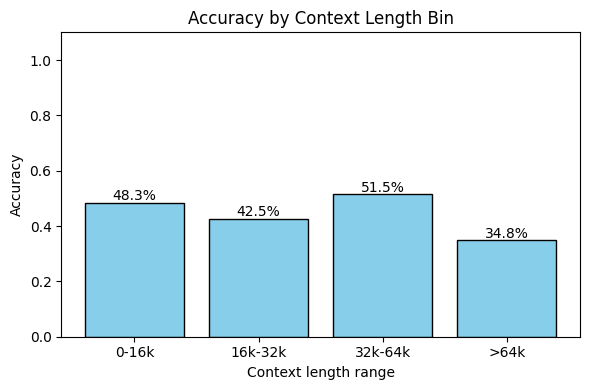

In [103]:
import pandas as pd
import matplotlib.pyplot as plt

# ---- 前面已经得到 stats ----
# stats = {label: {"total": .., "correct": ..} ...}

# 转成 DataFrame
df = pd.DataFrame([
    {
        "bin": label,
        "total": stats[label]["total"],
        "correct": stats[label]["correct"],
        "accuracy": stats[label]["correct"] / stats[label]["total"] if stats[label]["total"] > 0 else 0.0
    }
    for label in stats
])

df.to_csv("Qwen2.5-7B-Instruct.csv")

print(df)

# ---- 画图 ----
plt.figure(figsize=(6,4))
plt.bar(df["bin"], df["accuracy"], color="skyblue", edgecolor="black")
plt.ylabel("Accuracy")
plt.xlabel("Context length range")
plt.title("Accuracy by Context Length Bin")

# 在柱子上标注数值
for i, acc in enumerate(df["accuracy"]):
    plt.text(i, acc + 0.01, f"{acc:.1%}", ha="center", fontsize=10)

plt.ylim(0, 1.1)  # 留点空间放文字
plt.tight_layout()
plt.show()